In [1]:
#Load all required libraries
library(dplyr)
library(glmnet)
library(tidyr)
library(ggplot2)
library(reshape2)
library("ggpubr")
library(caret)
library(doParallel)
library(doMC)
registerDoMC(cores = 50)
library(pROC)
library(data.table)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: lattice
Loading required package: iterators
Loading required package: parallel
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:glmnet’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘data.table’

The following objects are masked fro

In [2]:
data_normalized=read.csv(file="20180206_ERPosNeg_Nanostring_normalized.csv",check.names=F,row.names=1)
head(data_normalized)
table(data_normalized$Group)
table(data_normalized$case)
dim(data_normalized)

,A2ML1,ABAT,ABCA13,ABCB4,ABHD2,ACTA2-AS1,ACTBP11,ACTBP2,ACTBP9,ACTC1,⋯,ZNF540,ZNF706,ZNF729,ZNF831,age,yearbbd,follow_years,impress,Group,case
50154,0.000000,0,0.000000,0,4.523562,0.000000,5.727920,8.317413,9.539159,0,⋯,0.000000,6.584963,6.000000,0.000000,50,1975,11.68,NP,ER+,Case
50170,0.000000,0,0.000000,0,4.954196,0.000000,6.169925,8.405141,9.623881,0,⋯,3.584963,5.954196,5.087463,1.000000,63,1970,12.31,PDWA,ER-,Case
50344,0.000000,0,0.000000,0,0.000000,0.000000,3.807355,10.818582,12.574830,0,⋯,0.000000,0.000000,0.000000,0.000000,49,1983,25.39,NP,cont,Case
50485,3.807355,0,4.169925,1,4.700440,6.066089,7.000000,9.428360,9.447083,0,⋯,4.906891,7.189825,8.348728,5.754888,50,1969,18.24,NP,cont,Case
50563,0.000000,0,5.459432,0,0.000000,0.000000,8.066089,10.423116,11.224605,0,⋯,3.169925,8.312883,8.614710,0.000000,65,1968,12.69,NP,ER-,Case
50590,0.000000,0,0.000000,0,5.807355,0.000000,6.392317,8.988685,10.121534,0,⋯,0.000000,6.629357,7.000000,0.000000,60,1974,18.57,PDWA,cont,Case



cont  ER-  ER+ 
  64   62   59 


   Case Control 
    126      59 

[1] 185 504

In [3]:
# data_normalized=(data_normalized[which(data_normalized$Group=='cont' & (data_normalized$case=='Case' | (data_normalized$case=='Control'))  ),])
# dim(data_normalized)
# head(data_normalized)
# table(data_normalized$case)

In [3]:
#reomve genes which are zeros along all subjects (504-488=16 genes)
data_normalized=data_normalized[, colSums(data_normalized != 0) > 0]
dim(data_normalized)

[1] 185 488

In [4]:
#remove age, yearbbd, follow_years, impress, group
data=data_normalized %>%  select(-c(age,yearbbd,follow_years,impress,case))
head(data)
dim(data)
table(data$Group)

,A2ML1,ABAT,ABCA13,ABCB4,ABHD2,ACTA2-AS1,ACTBP11,ACTBP2,ACTBP9,ACTG1P1,⋯,WNT4,YTHDF3,ZCCHC18,ZFAND3,ZNF322,ZNF540,ZNF706,ZNF729,ZNF831,Group
50154,0.000000,0,0.000000,0,4.523562,0.000000,5.727920,8.317413,9.539159,6.022368,⋯,0.000000,7.971544,0.000000,6.741467,5.169925,0.000000,6.584963,6.000000,0.000000,ER+
50170,0.000000,0,0.000000,0,4.954196,0.000000,6.169925,8.405141,9.623881,6.339850,⋯,0.000000,7.965784,0.000000,5.977280,4.906891,3.584963,5.954196,5.087463,1.000000,ER-
50344,0.000000,0,0.000000,0,0.000000,0.000000,3.807355,10.818582,12.574830,5.954196,⋯,0.000000,10.007027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,cont
50485,3.807355,0,4.169925,1,4.700440,6.066089,7.000000,9.428360,9.447083,6.857981,⋯,3.807355,8.596190,4.523562,6.643856,7.199672,4.906891,7.189825,8.348728,5.754888,cont
50563,0.000000,0,5.459432,0,0.000000,0.000000,8.066089,10.423116,11.224605,7.734710,⋯,0.000000,9.861087,0.000000,8.169925,8.400879,3.169925,8.312883,8.614710,0.000000,ER-
50590,0.000000,0,0.000000,0,5.807355,0.000000,6.392317,8.988685,10.121534,6.977280,⋯,0.000000,8.550747,0.000000,7.179909,5.807355,0.000000,6.629357,7.000000,0.000000,cont


[1] 185 483


cont  ER-  ER+ 
  64   62   59 

In [5]:
levels(data$Group)

[1] "cont" "ER-"  "ER+"

In [6]:
# ER+ and ER- as case 
levels(data$Group)=c('Control','Case','Control')
table(data$Group)


Control    Case 
    123      62 

In [7]:
# #Remove genes with zero variance
# #https://www.r-bloggers.com/near-zero-variance-predictors-should-we-remove-them/
# x = nearZeroVar(data, saveMetrics = TRUE)
# head(x[x[,"zeroVar"] > 0, ])
# head(x[x[,"zeroVar"] + x[,"nzv"] > 0, ])
# dim(x[x[,"zeroVar"] + x[,"nzv"] > 0, ])
# dim(x)

#  features selection using glmnet 

`geom_smooth()` using method = 'loess'


[1] 0.3333333

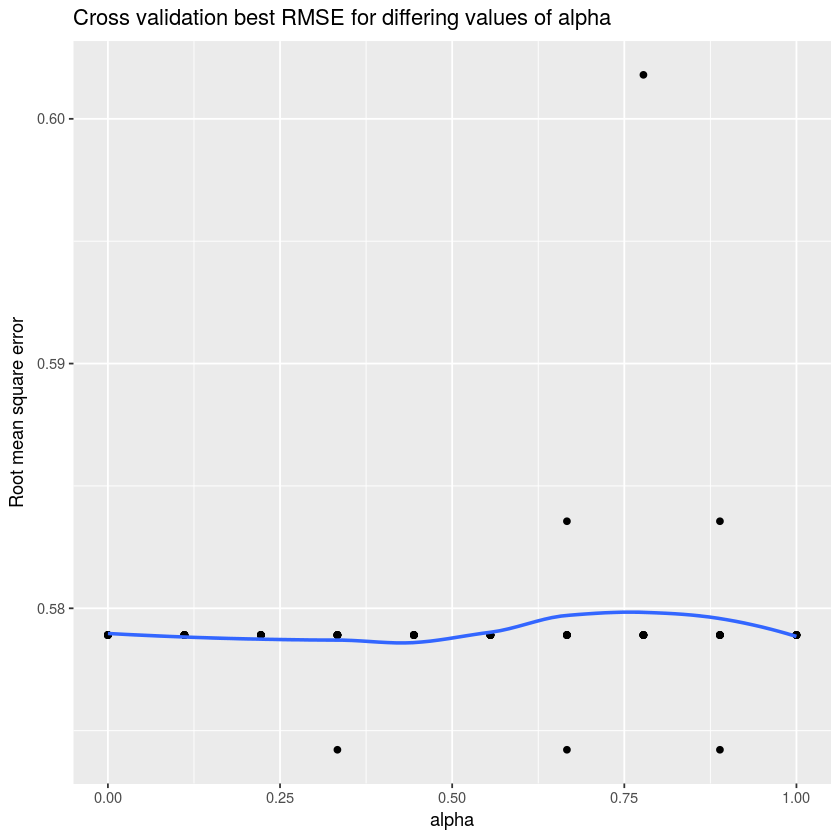

In [9]:
# selected genes with glmnet R packages 
#Find the best alpha
bestalpha=findalpha(data)
bestalpha

In [7]:
#' A Find the best alpha Function
#'
#' This function find the best alpha which give the least square root error
#'http://ellisp.github.io/blog/2016/08/13/fitbit-lasso
#' @param data The matrix you want to find the alpha
#' @keywords alpha
#' @export
#' @examples bestalpha=findalpha(data)
#' findalpha()
#'
#'

findalpha  <- function(data)  {
set.seed(123)
alphas <- seq(from = 0, to  = 1, length.out = 10)
numberOFrepeats=10
res <- matrix(0, nrow = length(alphas), ncol = numberOFrepeats) # five columns for results - five repeats of each CV run

x=data.matrix(data[,1:(ncol(data)-1)])
y=as.factor(data[,ncol(data)])
    
for(i in 1:length(alphas)){
   for(j in 2:numberOFrepeats){
      cvmod <- cv.glmnet(x, y , alpha = alphas[i],family='binomial',nfolds=10, 
                   standardize=TRUE, type.measure='class')
      res[i, c(1, j)] <- c(alphas[i], sqrt(min(cvmod$cvm)))
   }
}
res <- data.frame(res)
res$average_rmse <- apply(res[ , 2:numberOFrepeats], 1, mean)
res <- res[order(res$average_rmse), ]
names(res)[1] <- "alpha"

res1 <- res %>%
   select(-average_rmse) %>%
   gather(trial, rmse, -alpha)
    
  p= res1 %>% ggplot(aes(x = alpha, y = rmse)) +
   geom_point() +
   geom_smooth(se = FALSE) +
   labs(y = "Root mean square error") +
   ggtitle("Cross validation best RMSE for differing values of alpha")

   plot(p)
# best alpha varies according to the random seed set earlier but with seed 123 it is 0.22
  bestalpha <- res[1, 1]
    return(bestalpha)

}

In [12]:
#Find the best lampda
result=findlamda(data,bestalpha)
result$genes_list
result$consensus_genes

[[1]]
[1] "TUBA4A"

[[2]]
[1] "TUBA4A"

[[3]]
[1] "TUBA4A"

[[4]]
[1] "TUBA4A"

[[5]]
[1] "TUBA4A"

[[6]]
[1] "TUBA4A"

[[7]]
[1] "TUBA4A"

[[8]]
[1] "TUBA4A"

[[9]]
[1] "TUBA4A"

[[10]]
[1] "TUBA4A"

[1] "TUBA4A"

In [13]:
unique(unlist(result$genes_list))

[1] "TUBA4A"

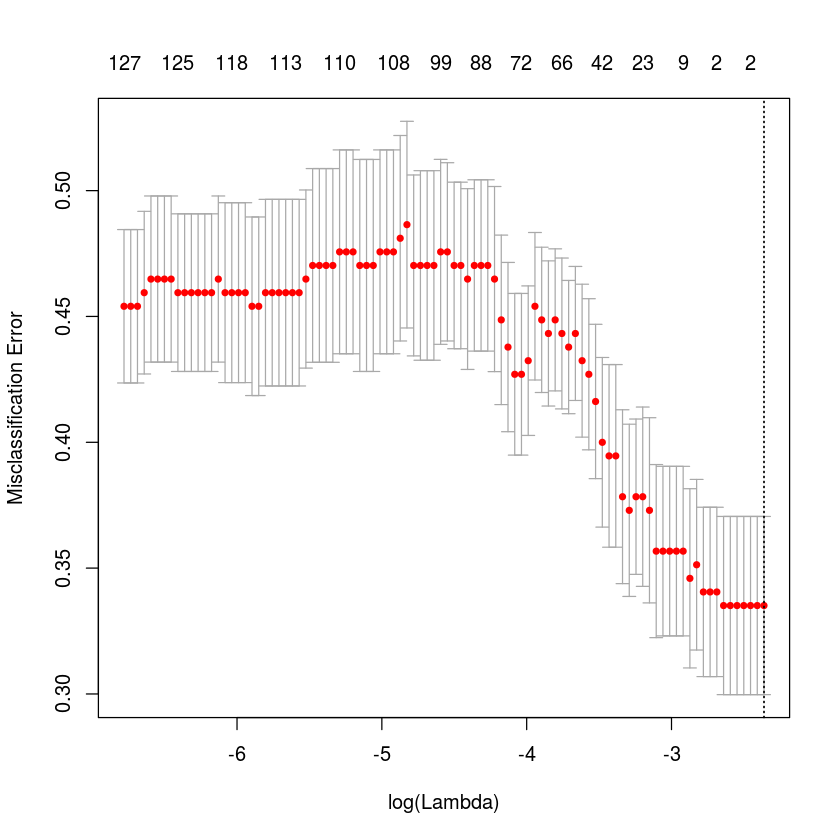

In [14]:
plot(result$model)

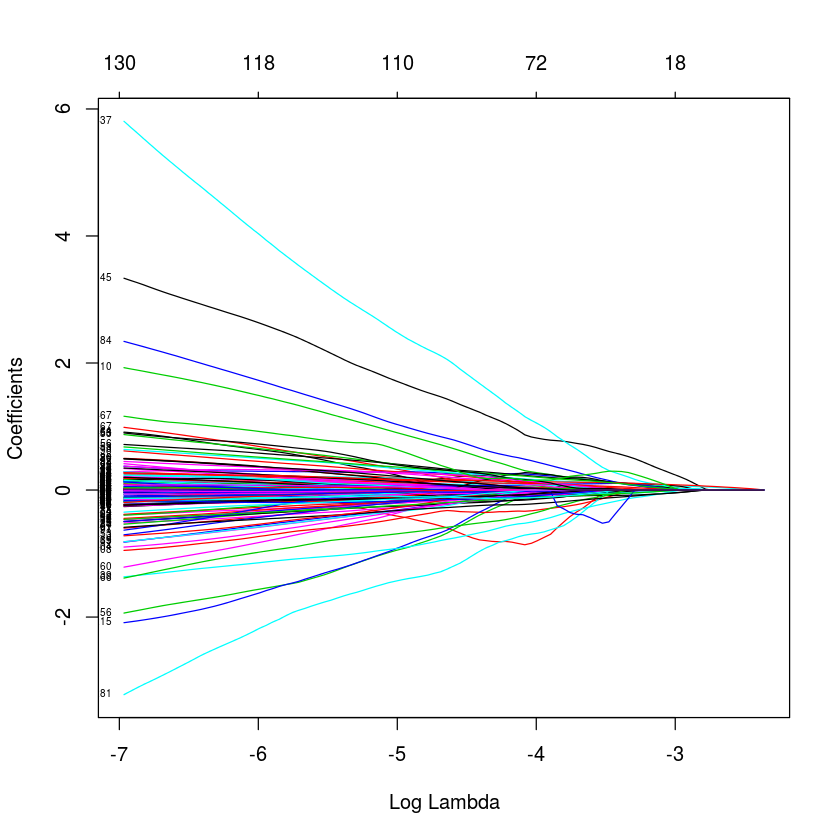

In [15]:
#https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html
plot(result$model$glmnet.fit, xvar="lambda", label=TRUE)

In [11]:
#' A Find the best lamda Function
#'
#' This function find the best lamda based on the best alpha
#'https://stats.stackexchange.com/questions/97777/variablity-in-cv-glmnet-results
#' @param data The matrix you want to find the best lampda and alpha you find from findalpha function
#' @keywords lamda
#' @export
#' @examples bestlamda=findalpha(data,bestalpha)
#' findlamda()
#'
#'

findlamda  <- function(data,bestalpha)  {
    
res = list()
    
lambdas = NULL
genes_list=list()
    

x=data.matrix(data[,1:(ncol(data)-1)])
y=as.factor(data[,ncol(data)])   
    
for (j in 1:10)
{
for (i in 1:100)
{
  #fit <- cv.glmnet(x, y, family='binomial',nfolds=10, 
       #            standardize=TRUE, type.measure='class')
    
    #cv.glmnet does NOT search for values for alpha. A specific value should be supplied, else alpha=1 is assumed by default.
    
    fit <- cv.glmnet(x, y, family='binomial',nfolds=10, 
                   standardize=TRUE, type.measure='class',alpha=1)
    
  errors = data.frame(fit$lambda,fit$cvm)
  lambdas <- rbind(lambdas,errors)
}
# take mean cvm for each lambda
lambdas <- aggregate(lambdas[, 2], list(lambdas$fit.lambda), mean)

# select the best one
bestindex = which(lambdas[2]==min(lambdas[2]))
bestlambda = lambdas[bestindex,1]
    
res$bestlambda=bestlambda
res$model=fit    
lambdas = NULL
cv.lasso<- glmnet(x, y,lambda=bestlambda,family='binomial',standardize=TRUE)

zz=as.matrix(coef(cv.lasso, s=bestlambda)[,1])

zz1=as.matrix(zz[order(abs(zz[,1]),decreasing = T),])

zz2=data.frame(zz1[zz1!=0 & rownames(zz1)!="(Intercept)",1])
colnames(zz2)="coffiecents"

genes_list[[j]]=rownames(zz2)
}
    

    
genes_list_consensus=Reduce(intersect,genes_list) 
genes_list_consensus=make.names(genes_list_consensus, unique=TRUE)
    
res$consensus_genes=genes_list_consensus
res$genes_list=genes_list   
    
return(res)
    
    }

In [16]:
lasso_data=data %>% select(unique(unlist(result$genes_list)),ncol(data))
head(lasso_data)
dim(lasso_data)

,TUBA4A,Group
50154,1.584963,Control
50170,4.700440,Case
50344,0.000000,Control
50485,0.000000,Control
50563,0.000000,Case
50590,1.584963,Control


[1] 185   2

Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message:
“Removed 1 rows containing missing values (position_stack).”

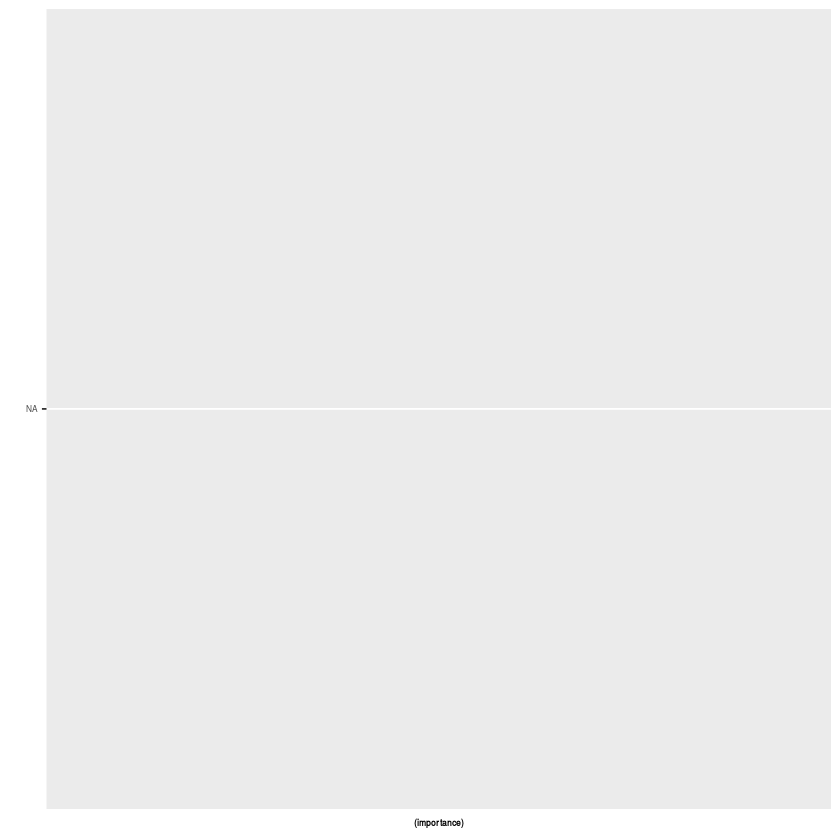

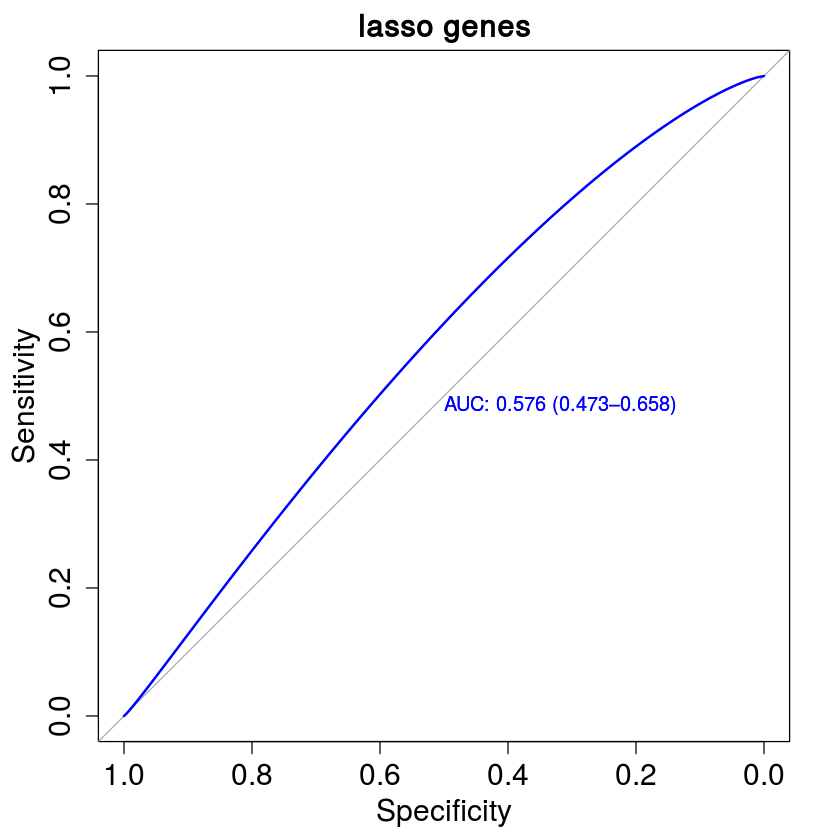

In [19]:
seed=1024
numberoffolds=5
find_roc_range(lasso_data,numberoffolds,seed,"lasso genes")
#find_roc_range(lasso_data,numberoffolds,seed,"lasso genes")

In [20]:
lasso_melted_data=melt(lasso_data)
head(lasso_melted_data)

Using Group as id variables


Group,variable,value
Control,TUBA4A,1.584963
Case,TUBA4A,4.700440
Control,TUBA4A,0.000000
Control,TUBA4A,0.000000
Case,TUBA4A,0.000000
Control,TUBA4A,1.584963


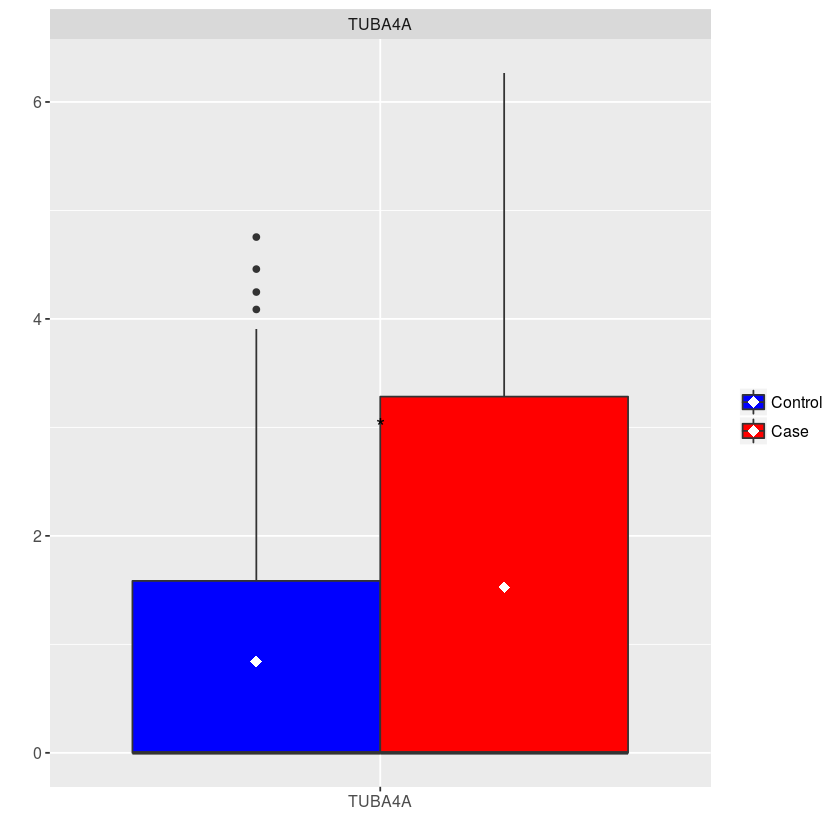

In [21]:
p <- ggplot(data =lasso_melted_data, aes(x=variable, y=value,fill=lasso_melted_data[,1])) + 
  geom_boxplot()+scale_fill_manual(values=c("blue", "red"))+
         stat_summary(fun.y="mean", color="white", geom="point",shape=18, size=3,position=position_dodge(width=0.75))+
  theme(text = element_text(size=12),
        axis.text.x = element_text(angle=0),legend.title=element_blank())+
stat_compare_means(label="p.signif",method = "t.test",label.x = 1, label.y = 3,size = 5)
 p+ facet_wrap( ~ variable, scales="free")+xlab("")+ylab("")


#  features selection using statistics test 

In [22]:
# Just print the signficant metabolites <0.05  using glm
signficant_metab='NA'
for (i in 1:(ncol(data)-1)){
a= (summary((glm(data[,i]~
               Group,data=data))))
if(a$coefficients[2,4] <=0.05 )
{print(colnames(data)[i])
signficant_metab=append(signficant_metab,colnames(data)[i])} 
}
signficant_metab=signficant_metab[-1]
signficant_metab
length(signficant_metab)

[1] "BLK"
[1] "DCUN1D5"
[1] "PELI2"
[1] "SLC14A1"
[1] "TMEM183A"
[1] "TUBA4A"


[1] "BLK"      "DCUN1D5"  "PELI2"    "SLC14A1"  "TMEM183A" "TUBA4A"

[1] 6

In [23]:
# Just print the signficant metabolites <0.05 using t.test
signficant_metab1='NA'
for (i in 1:(ncol(data)-1)){
a= t.test(data[,i]~ Group,data=data)  
if(a$p.value <=0.05 )
{print(colnames(data)[i])
signficant_metab1=append(signficant_metab1,colnames(data)[i])} 
}
signficant_metab1=signficant_metab1[-1]
signficant_metab1
length(signficant_metab1)

[1] "DCUN1D5"
[1] "PELI2"
[1] "TUBA4A"


[1] "DCUN1D5" "PELI2"   "TUBA4A"

[1] 3

In [24]:
length(intersect(signficant_metab,signficant_metab1))

[1] 3

In [27]:
significant_data=data.frame(data[,signficant_metab1],label=data[,ncol(data)])
head(significant_data)
dim(significant_data)

,DCUN1D5,PELI2,TUBA4A,label
50154,0.000000,0.000000,1.584963,Control
50170,2.807355,2.807355,4.700440,Case
50344,0.000000,0.000000,0.000000,Control
50485,0.000000,0.000000,0.000000,Control
50563,0.000000,0.000000,0.000000,Case
50590,0.000000,0.000000,1.584963,Control


[1] 185   4

Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”

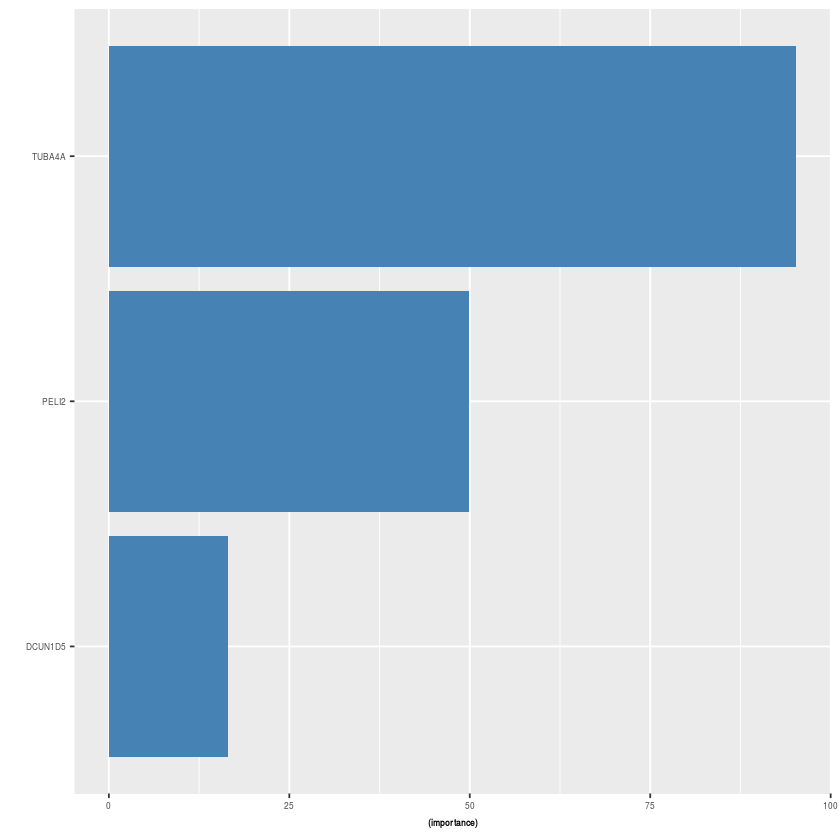

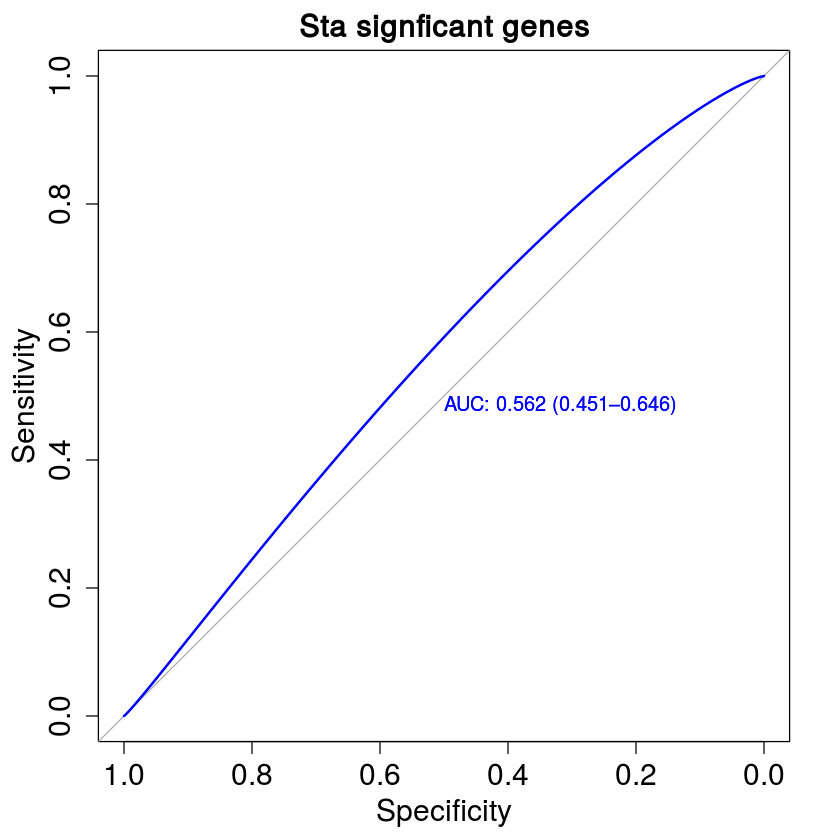

In [28]:
seed=1024
numberoffolds=5
find_roc_range(significant_data,numberoffolds,seed,"Sta signficant genes")

In [29]:
significant_melted_data=melt(significant_data)
head(significant_melted_data)

Using label as id variables


label,variable,value
Control,DCUN1D5,0.000000
Case,DCUN1D5,2.807355
Control,DCUN1D5,0.000000
Control,DCUN1D5,0.000000
Case,DCUN1D5,0.000000
Control,DCUN1D5,0.000000


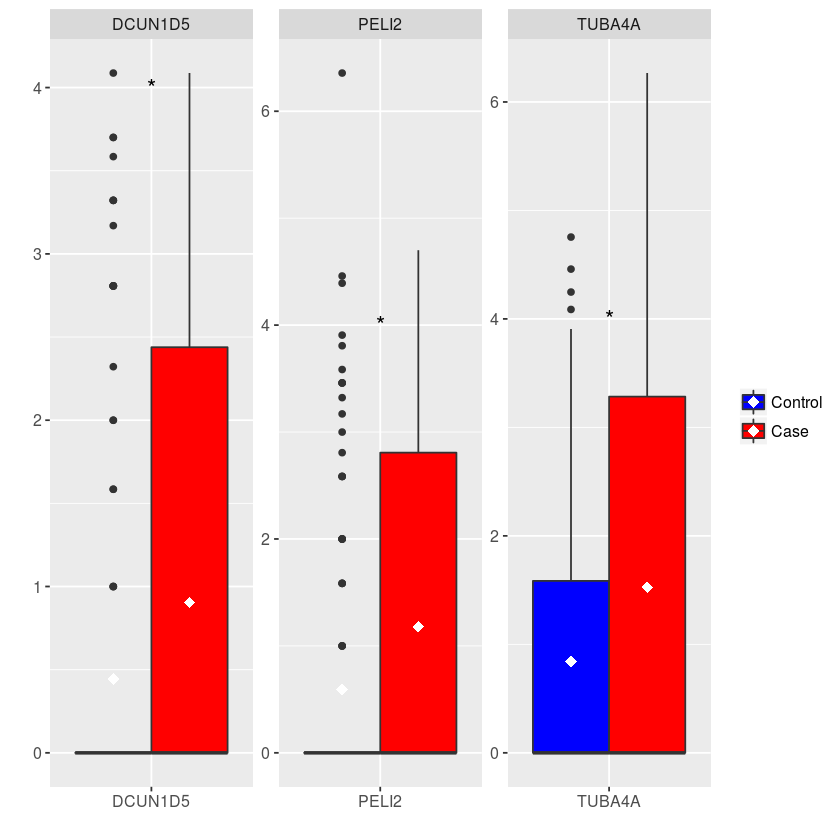

In [30]:
p <- ggplot(data =significant_melted_data, aes(x=variable, y=value, fill=significant_melted_data[,1] )) + 
  geom_boxplot()+scale_fill_manual(values=c("blue", "red"))+
         stat_summary(fun.y="mean", color="white", geom="point",shape=18, size=3,position=position_dodge(width=0.75))+
  theme(text = element_text(size=12),
        axis.text.x = element_text(angle=0),legend.title=element_blank())+
stat_compare_means(label="p.signif",method = "t.test",label.x = 1, label.y = 4,size = 5,paired=F)
 p+ facet_wrap( ~ variable, scales="free")+xlab("")+ylab("")

#  features selection using CARET  recursive feature elimination

In [31]:
set.seed(123)
control <- rfeControl(functions=rfFuncs, method="cv", number=10)

In [32]:
rfe.train <- rfe(data[,1:(ncol(data)-1)], data[,ncol(data)]  , sizes=1:(ncol(data)-1), rfeControl=control)

In [33]:
rfe.train


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy      Kappa AccuracySD KappaSD Selected
         1   0.5997 -3.612e-02    0.08375  0.2066         
         2   0.5772 -4.999e-02    0.12685  0.2579         
         3   0.5827 -9.037e-02    0.08167  0.1684         
         4   0.5620 -9.301e-02    0.05315  0.1436         
         5   0.5845 -2.316e-02    0.08673  0.1796         
         6   0.5901 -2.466e-02    0.08994  0.2040         
         7   0.5734 -8.236e-02    0.10439  0.2301         
         8   0.5898 -4.480e-02    0.09099  0.2038         
         9   0.5895 -2.203e-03    0.11873  0.2534         
        10   0.5845 -2.810e-02    0.12189  0.2591         
        11   0.5737 -6.868e-02    0.11723  0.2605         
        12   0.5792 -6.829e-02    0.11463  0.2464         
        13   0.5740 -8.585e-02    0.10594  0.2070         
        14   0.5798 -5.637e-02    0.13604  0.2532

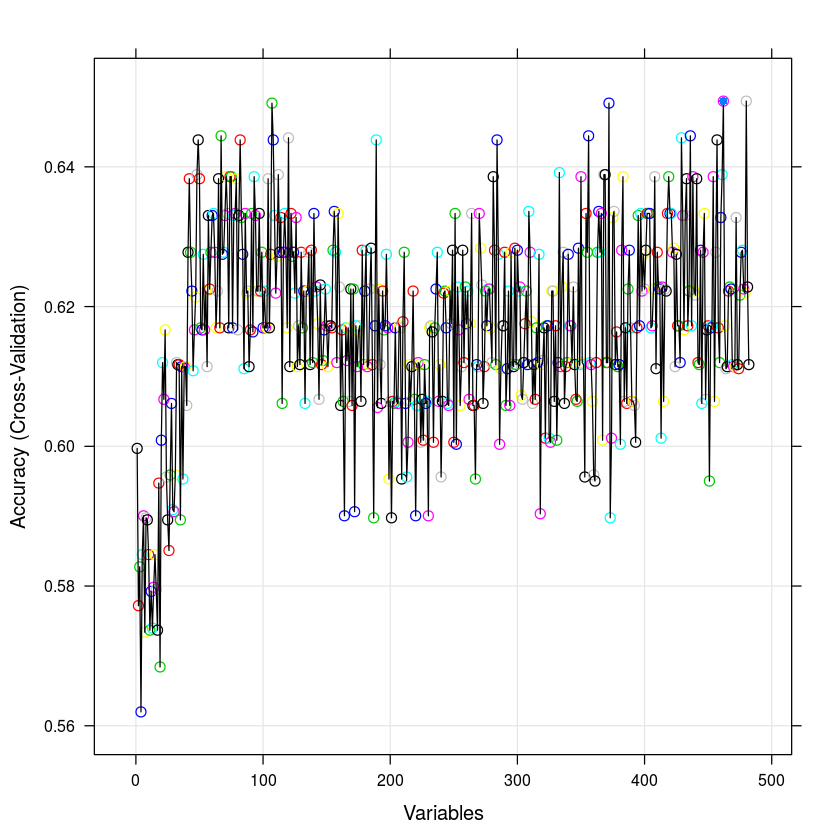

In [34]:
plot(rfe.train, type=c("g", "o"), cex = 1.0, col = 1:(ncol(data)-2))

In [36]:
length(predictors(rfe.train))

[1] 462

In [ ]:
The top 5 variables (out of 462):
   CUL3, NOS1AP, TMEM183A, CDHR1, PELI2


In [37]:
rfe_data=data.frame(data[,c('CUL3', 'NOS1AP', 'TMEM183A', 'CDHR1', 'PELI2')],label=data[,ncol(data)])
head(rfe_data)
dim(rfe_data)

,CUL3,NOS1AP,TMEM183A,CDHR1,PELI2,label
50154,5.129283,0,0,0.000000,0.000000,Control
50170,5.459432,0,0,0.000000,2.807355,Case
50344,0.000000,0,0,0.000000,0.000000,Control
50485,0.000000,0,0,5.554589,0.000000,Control
50563,0.000000,0,0,0.000000,0.000000,Case
50590,5.169925,0,0,0.000000,0.000000,Control


[1] 185   6

Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”

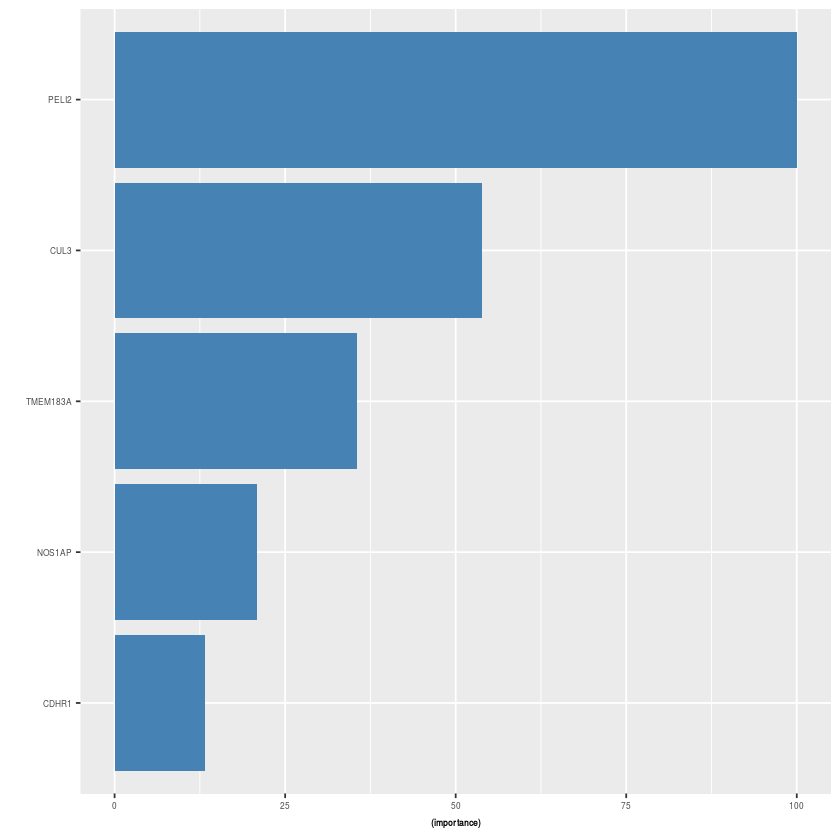

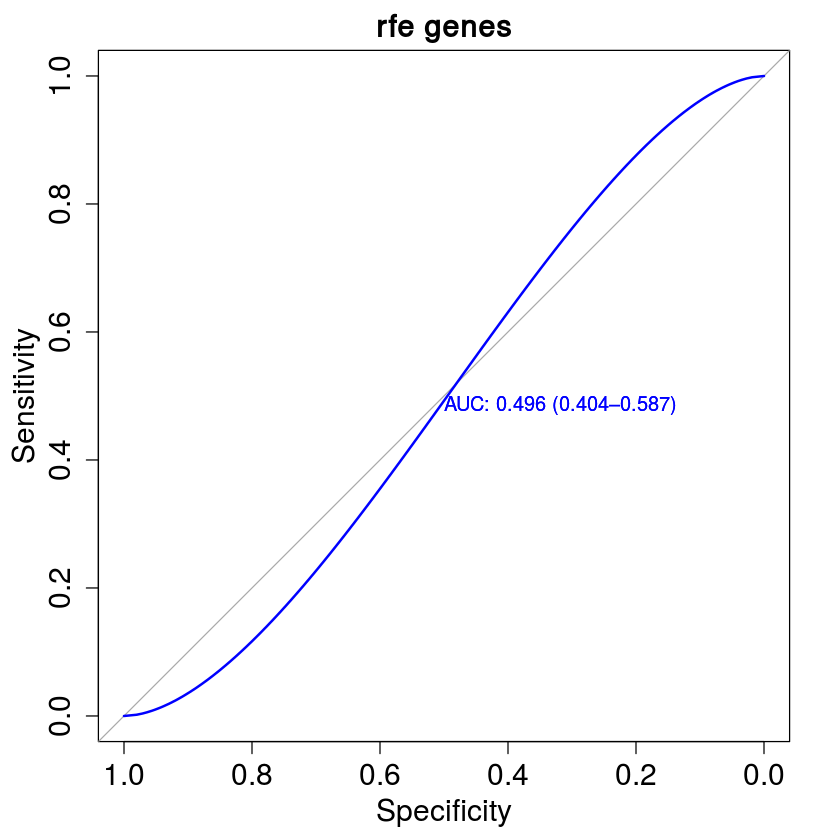

In [38]:
seed=1024
numberoffolds=5
find_roc_range(rfe_data,numberoffolds,seed,"rfe genes")

In [39]:
rfe_melted_data=melt(rfe_data)
head(rfe_melted_data)

Using label as id variables


label,variable,value
Control,CUL3,5.129283
Case,CUL3,5.459432
Control,CUL3,0.000000
Control,CUL3,0.000000
Case,CUL3,0.000000
Control,CUL3,5.169925


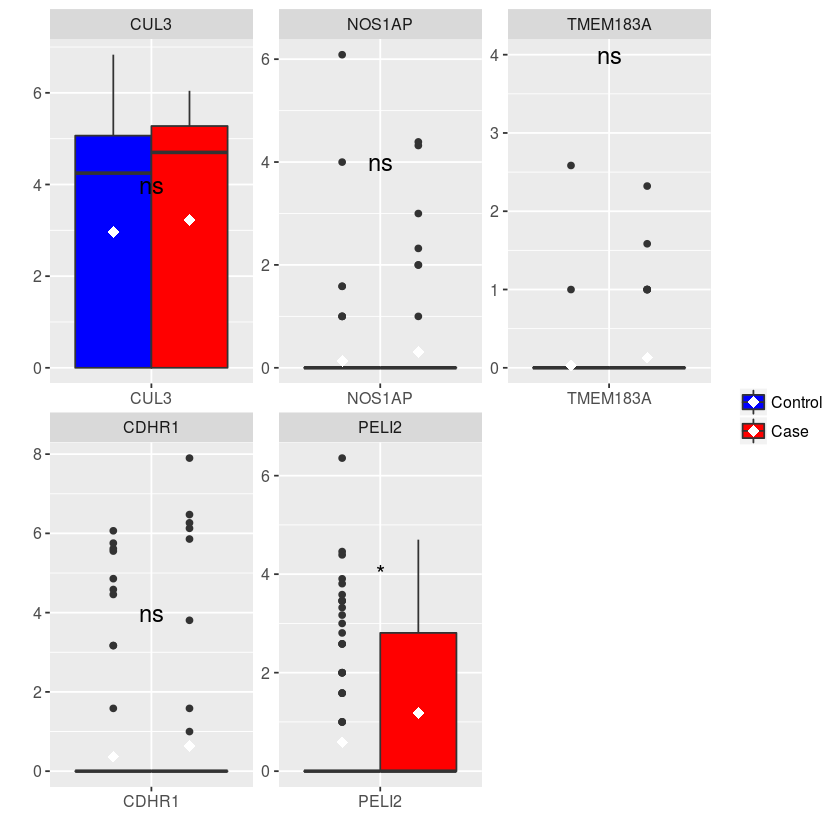

In [40]:
p <- ggplot(data =rfe_melted_data, aes(x=variable, y=value,fill=rfe_melted_data[,1])) + 
  geom_boxplot()+scale_fill_manual(values=c("blue", "red"))+
         stat_summary(fun.y="mean", color="white", geom="point",shape=18, size=3,position=position_dodge(width=0.75))+
  theme(text = element_text(size=12),
        axis.text.x = element_text(angle=0),legend.title=element_blank())+
stat_compare_means(label="p.signif",method = "t.test",label.x = 1, label.y = 4,size = 5,paired=F)
 p+ facet_wrap( ~ variable, scales="free")+xlab("")+ylab("")

#  features selection using Boruta

In [41]:
#install.packages("Boruta")
library(Boruta)

Loading required package: ranger


In [42]:
boruta.train <- Boruta(Group~., data = data, doTrace = 2)

 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
 11. run of importance source...
 12. run of importance source...
 13. run of importance source...
 14. run of importance source...
 15. run of importance source...
 16. run of importance source...
After 16 iterations, +5.6 secs: 
 rejected 477 attributes: A2ML1, ABAT, ABCA13, ABCB4, ABHD2 and 472 more;
 still have 5 attributes left.

 17. run of importance source...
 18. run of importance source...
 19. run of importance source...
 20. run of importance source...
After 20 iterations, +5.8 secs: 
 rejected 1 attribute: RPSAP53;
 still have 4 attributes left.

 21. run of importance source...
 22. run of importance source...
 23. run of importance source...
 24. run of im

In [43]:
print(boruta.train)

Boruta performed 99 iterations in 8.430512 secs.
 3 attributes confirmed important: BTBD11, CUL3, PELI2;
 478 attributes confirmed unimportant: A2ML1, ABAT, ABCA13, ABCB4,
ABHD2 and 473 more;
 1 tentative attributes left: ATP6V0B;


In [44]:
final.boruta <- TentativeRoughFix(boruta.train)
 print(final.boruta)

Boruta performed 99 iterations in 8.430512 secs.
Tentatives roughfixed over the last 99 iterations.
 3 attributes confirmed important: BTBD11, CUL3, PELI2;
 479 attributes confirmed unimportant: A2ML1, ABAT, ABCA13, ABCB4,
ABHD2 and 474 more;


In [46]:
boruta_data=data.frame(data[,c('BTBD11', 'CUL3', 'PELI2'),drop=F],label=data[,ncol(data)])
head(boruta_data)
dim(boruta_data)

,BTBD11,CUL3,PELI2,label
50154,0,5.129283,0.000000,Control
50170,0,5.459432,2.807355,Case
50344,0,0.000000,0.000000,Control
50485,0,0.000000,0.000000,Control
50563,0,0.000000,0.000000,Case
50590,0,5.169925,0.000000,Control


[1] 185   4

In [47]:
boruta_melted_data=melt(boruta_data)
head(boruta_melted_data)

Using label as id variables


label,variable,value
Control,BTBD11,0
Case,BTBD11,0
Control,BTBD11,0
Control,BTBD11,0
Case,BTBD11,0
Control,BTBD11,0


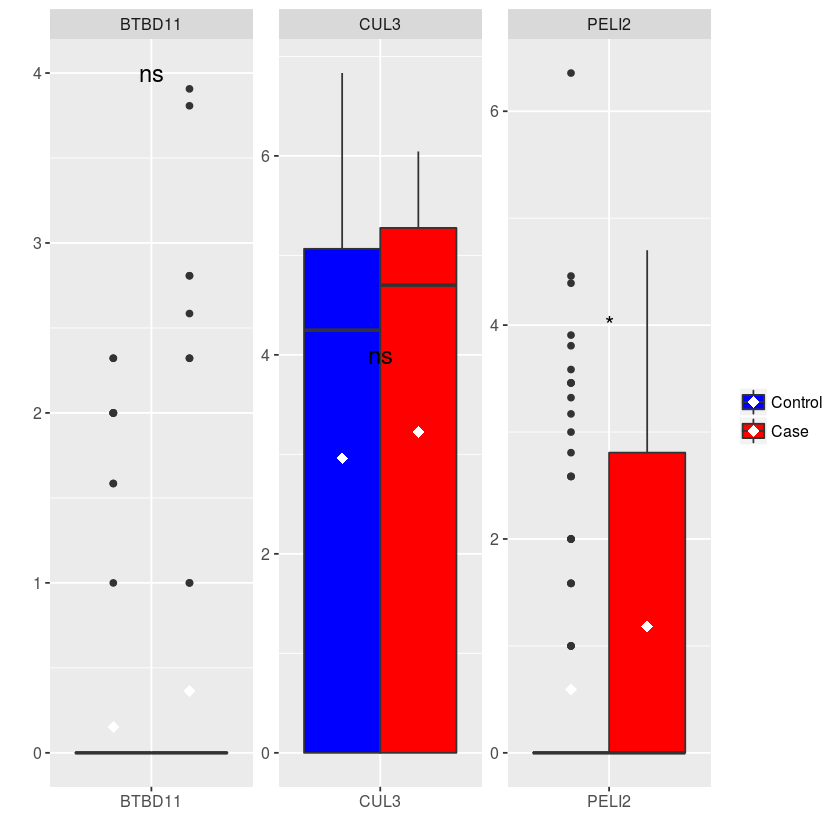

In [48]:
p <- ggplot(data =boruta_melted_data, aes(x=variable, y=value,fill=boruta_melted_data[,1])) + 
  geom_boxplot()+scale_fill_manual(values=c("blue", "red"))+
         stat_summary(fun.y="mean", color="white", geom="point",shape=18, size=3,position=position_dodge(width=0.75))+
  theme(text = element_text(size=12),
        axis.text.x = element_text(angle=0),legend.title=element_blank())+
stat_compare_means(label="p.signif",method = "t.test",label.x = 1, label.y = 4,size = 5,paired=F)
 p+ facet_wrap( ~ variable, scales="free")+xlab("")+ylab("")

Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”

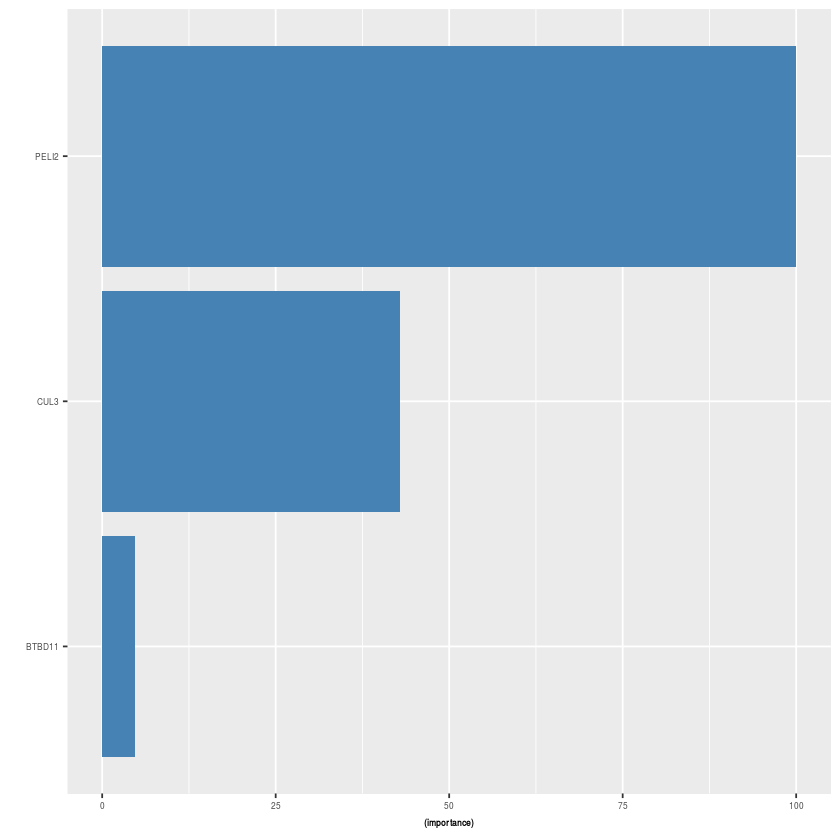

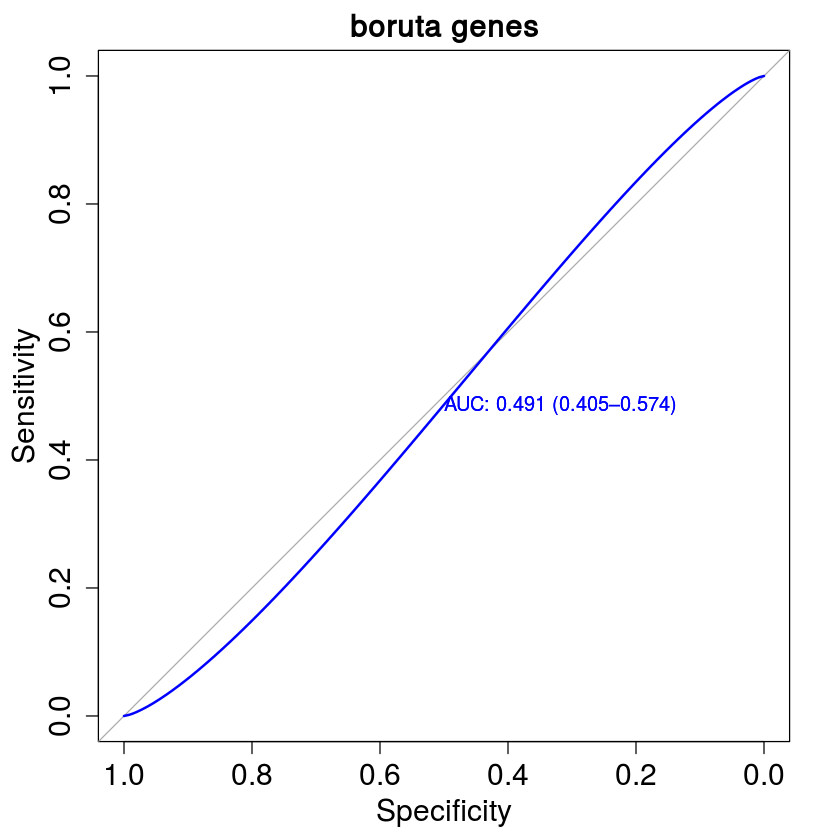

In [49]:
seed=1024
numberoffolds=5
find_roc_range(boruta_data,numberoffolds,seed,"boruta genes")

# Classification

In [18]:
find_roc_range=function(data,k,seed,data_name){
set.seed(seed)
#data.names.list=c('Metabolomics 230','Metabolimcs_elastic_net','Covariates','Covariates and Metabolimcs_elastic_net')
#data.names.list_id=0
splits <- createFolds(data[,ncol(data)], returnTrain = TRUE,k = k)
results <- lapply(splits, 
                  function(x, dat) {
                    holdout <- (1:nrow(dat))[-unique(x)]
                    data.frame(index = holdout, 
                               obs = dat[,ncol(dat)][holdout])
                  },
                  dat = data)
mods <- vector(mode = "list", length = length(splits))
roc <- vector(mode = "list", length = length(splits))
## foreach or lapply would do this faster
for(i in seq(along = splits)) {
  in_train <- unique(splits[[i]])
  set.seed(seed)
  TrainData <- data[in_train, -ncol(data),drop=F]
  TrainClasses <- data[in_train, ncol(data)]

  mod <- train( TrainData, TrainClasses,
               method = "regLogistic", #tuneLength=15, #cost (Cost) loss (Loss Function)  epsilon (Tolerance)  #"regLogistic"
               preProc = c("center", "scale"),trControl=trainControl (method="cv",number=10, 
                     summaryFunction=twoClassSummary,classProbs=T,savePredictions = T,allowParallel = TRUE)
               )

  #results[[i]]$pred <- predict(mod, data[-in_train,!(colnames(data) %in% c('label')) ],type="prob")
    results[[i]]$pred <- predict(mod, data[-in_train, !(colnames(data) %in% colnames(data)[ncol(data)] ),drop=F ],type="prob")
    roc[[i]]<- roc(predictor=as.numeric(unlist(results[[i]]$pred[1])), response=data[-in_train,colnames(data)[ncol(data)]],
                 levels=rev(levels(data[-in_train,colnames(data)[ncol(data)] ])))#,smooth=TRUE)
    mods[[i]] <- mod
  
}

###############How to plot concatante variables importance from 5 models
important_featurs=(lapply(mods,function(xx) (varImp(xx,scale=T))))
important_featurs_list=(lapply(important_featurs,function(x) data.frame(x$importance)))
important_featurs_list2=data.frame((lapply(important_featurs_list,function(x) (x[1]))))
#print(important_featurs_list2)
important_featurs2=data.frame(apply(important_featurs_list2,1,mean ))
#print(important_featurs2)

colnames(important_featurs2)='importance'
zz=important_featurs2[order(-important_featurs2$importance),,drop=F]

zz=(zz[apply(zz, 1, function(row) all(row !=0 )),,drop=F])
zz=(zz[apply(zz, 1, function(row) all(row >0 )),,drop=F])

#pdf("metabolites_230_importance.pdf")
#pdf("covariates_importance.pdf",width=10,height=10)
#pdf("metabolites_lasso_importance.pdf",width=10,height=10)
#pdf("covariates_and_lasso_importance.pdf",width=10,height=10)
p=ggplot(data=zz,aes(x=reorder(rownames(zz),importance), y=(importance))) +
geom_bar(stat="identity",fill="steelblue")+
xlab("")+theme(axis.text=element_text(size=5),axis.title=element_text(size=5,face="bold"))
p1=p+coord_flip()
print(p1)
#dev.off()

predicted_57=(rbindlist(lapply(results,function(x) data.frame(index=x$index,obs=x$obs,pre=x$pred))))
#pdf("metabolites_230_ROC.pdf")
#pdf("covariates_ROC.pdf",width=10,height=10)
#pdf("metabolites_lasso_ROC.pdf",width=10,height=10)
#pdf("covariates_and_lasso_ROC.pdf",width=10,height=10)

plot(roc(predictor=as.numeric(unlist(predicted_57[,4])),response=predicted_57$obs,levels=rev(levels(predicted_57$obs)),
         smooth=TRUE,ci=TRUE)
     ,print.auc = TRUE, main = paste0(data_name),col='blue',cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
#dev.off()

#print(predicted_57)  
#print(results)
#print(roc)
#lapply(roc, function(x)plot(x,print.auc = TRUE))
#cat(sprintf("The average AUC of %d fold changes is %f ", k, mean(as.numeric(lapply(roc,function(x) (x$auc))))))
clab = 0.1
cmain = 0.1
caxis = 0.1
#lapply(mods,function(x) plot(varImp(x,scale=T),cex.lab=clab,cex.main =cmain,cex.axis=caxis))
#lapply(mods,function(x) plot(varImp(x,scale=T),20,cex.lab=clab,cex.main =cmain,cex.axis=caxis))
#:lapply(mods,function(x) plot(x))	
    }
   

Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”Warning message in train.default(TrainData, TrainClasses, method = "regLogistic", :
“The metric "Accuracy" was not in the result set. ROC will be used instead.”

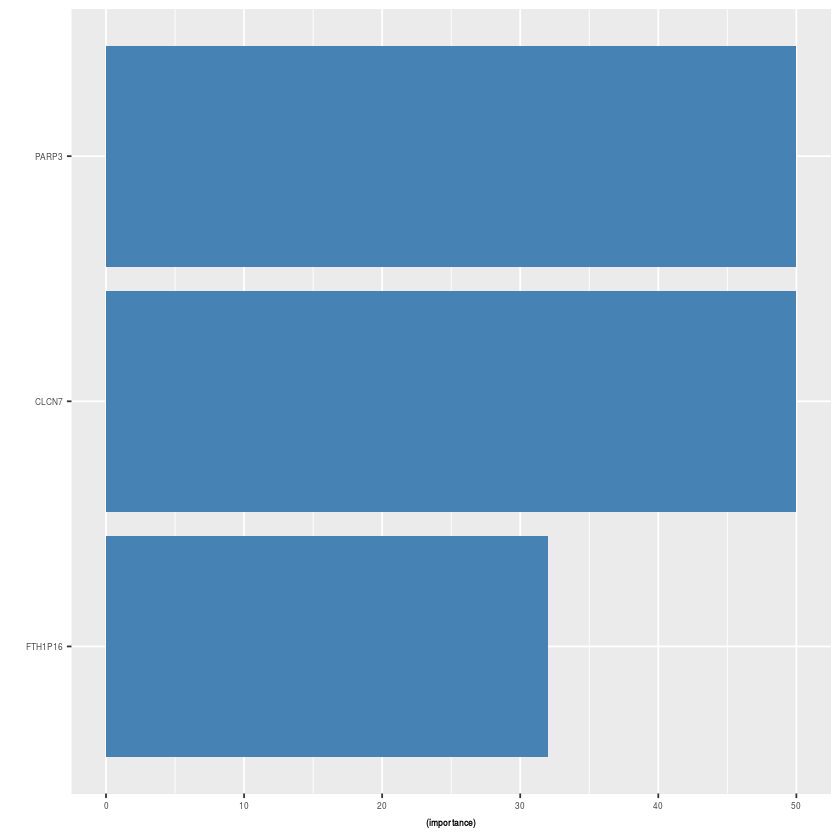

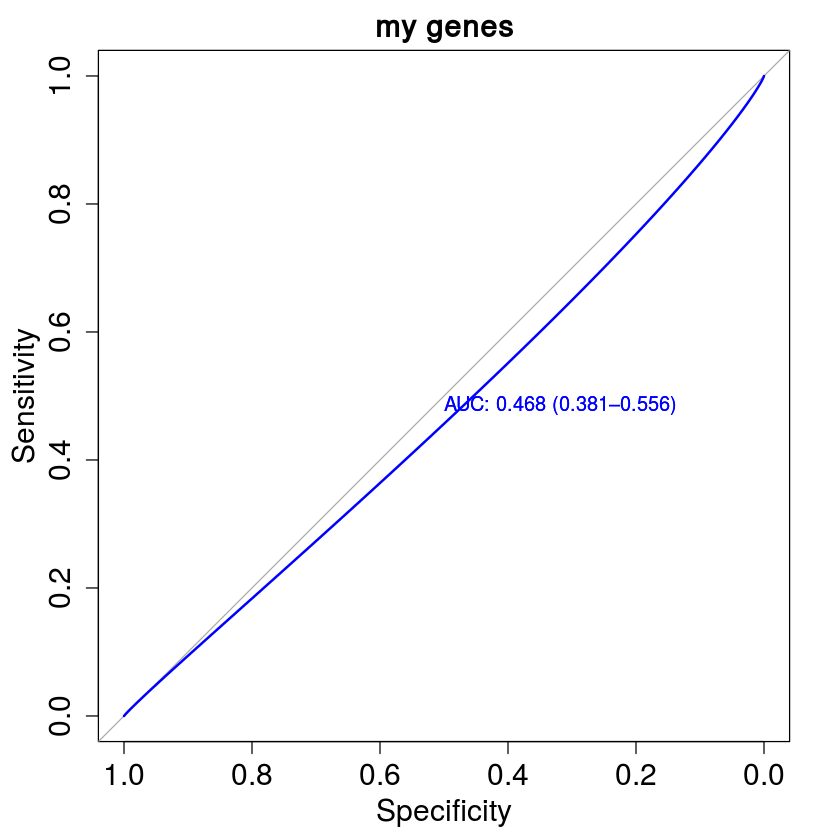

In [50]:
mydata=data[,c('CLCN7','FTH1P16','PARP3','Group')]
seed=1024
numberoffolds=2
find_roc_range(mydata,numberoffolds,seed,"my genes")